In [1]:
import pandas as pd
import numpy as np
import os.path as op
import torch
import math
from models import SelfNet
import argparse
import os
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from PIL import Image

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

/home/mchen/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
year=1995
images = np.memmap(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
# print(images.shape)
label_df = pd.read_feather(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
rets = np.array(label_df['Ret_20d'])

images = images/255.0
rets[rets>0] = 1
rets[rets!=1] = 0
print('postive num:',sum(rets==1),'negative num:',sum(rets==0))

data_x = torch.from_numpy(images).type(torch.FloatTensor)
data_y = torch.from_numpy(rets).to(torch.int64) 

data_x = torch.unsqueeze(data_x,dim=1)

postive num: 53692 negative num: 44015


In [3]:
print(images.shape)

(97707, 64, 60)


In [4]:
print(images.shape)

(97707, 64, 60)


In [5]:
test_dataset = TensorDataset(data_x,data_y)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [6]:
state = torch.load('/home/mchen/hkust_coursework/MATH_5470/final_project/checkpoints/rgstoreFalse_start1993_period8_preds20_lr1e-05_epoch200_bnTrue_xinitTrue_1stout64_layers3_drop0.5_lrelu_mp(2, 1)_flt(5, 3)_dlt(1, 1)_strd(1, 1)_best.cpt')
# state = torch.load('/home/mchen/hkust_coursework/MATH_5470/final_project/checkpoints/rgstoreTrue_start1993_period8_preds20_lr1e-05_epoch200_bnTrue_xinitTrue_1stout64_layers3_drop0.5_lrelu_mp(2, 1)_flt(5, 3)_dlt(2, 1)_strd(1, 1)_50th.cpt')
# state = torch.load('/home/mchen/hkust_coursework/MATH_5470/final_project/checkpoints/rgstoreFalse_start1993_period8_preds20_lr1e-05_epoch200_bnFalse_xinitTrue_1stout64_layers3_drop0.5_lrelu_mp(2, 1)_flt(5, 3)_dlt(2, 1)_strd(1, 1)_best.cpt')
# state = torch.load('/home/mchen/hkust_coursework/MATH_5470/final_project/checkpoints/rgstoreFalse_start1993_period8_preds20_lr1e-05_epoch200_bnTrue_xinitTrue_1stout64_layers3_drop0.5_lrelu_mp(2, 1)_flt(3, 3)_dlt(2, 1)_strd(1, 1)_best.cpt')
# state = torch.load('/home/mchen/hkust_coursework/MATH_5470/final_project/checkpoints/rgstoreFalse_start1993_period8_preds20_lr1e-05_epoch200_bnTrue_xinitTrue_1stout64_layers3_drop0.5_lrelu_mp(2, 2)_flt(3, 3)_dlt(1, 1)_strd(1, 1)_best.cpt')
model = state['net']

In [7]:
best_pic_num = 30

In [8]:
a = torch.empty(3, 3).uniform_(0, 1)
a = torch.bernoulli(a)
print(a[a==0])
print(torch.argmax(a))

tensor([0., 0., 0., 0., 0.])
tensor(0)


In [9]:
img_path = '/home/mchen/hkust_coursework/MATH_5470/final_project/ori_20d_imgs'
if not os.path.exists(img_path):
    os.mkdir(img_path)

In [10]:
for i,data in enumerate(test_loader):
    if i>best_pic_num:
        break
    inputs,labels = data
    inputs,labels = inputs.cuda(),labels.cuda()
    outputs = model(inputs)
    pred_labels = torch.argmax(outputs,dim=1)

    up_idx = labels==1
    down_idx = labels==0
    # print(up_idx,down_idx)

    up_labels, should_pred_up_labels = labels[up_idx], pred_labels[up_idx]
    down_labels, should_pred_down_labels = labels[down_idx], pred_labels[down_idx]
    up_inputs, down_inputs = inputs[up_idx], inputs[down_idx]
    up_logits,down_logits = outputs[up_idx], outputs[down_idx]
    # up_logits,down_logits = up_logits[:,1], down_logits[:,0]
    up_logits,down_logits = up_logits[:,1]-up_logits[:,0], down_logits[:,0]-down_logits[:,1]

    up_labels_err, down_labels_err = up_labels-should_pred_up_labels, down_labels-should_pred_down_labels
    corret_up_pos, correct_down_pos = up_labels_err==0, down_labels_err==0

    correct_up_inputs, correct_down_inputs = up_inputs[corret_up_pos], down_inputs[correct_down_pos]
    correct_up_logits, correct_down_logits = up_logits[corret_up_pos], down_logits[correct_down_pos]
    # topn_up_logits_pos, topn_down_logtis_pos = torch.argmax(correct_up_logits)[:best_pic_num], torch.argmax(correct_down_logits)[:best_pic_num]
    # print('correct_up_logits, correct_down_logits',correct_up_logits, correct_down_logits)
    # print('corret_up_pos, correct_down_pos',corret_up_pos, correct_down_pos)
    top1_up_logits_pos, top1_down_logtis_pos = torch.argmax(correct_up_logits), torch.argmax(correct_down_logits)
    print('current correct top 1 up and down logits:',correct_up_logits[top1_up_logits_pos],correct_down_logits[top1_down_logtis_pos])
    topn_up_imgs, topn_down_imgs = correct_up_inputs[top1_up_logits_pos], correct_down_inputs[top1_down_logtis_pos]
    topn_up_imgs *= 255
    topn_down_imgs *= 255
    # print(topn_up_imgs.size())
    # print(topn_down_imgs.size())

    # for ii in range(best_pic_num):

    down_img_name = os.path.join(img_path,'down_%s.png'%i) 
    down_img = Image.fromarray(topn_down_imgs.squeeze(0).detach().cpu().numpy().astype('uint8'))
    down_img.save(down_img_name)

    up_img_name = os.path.join(img_path,'up_%s.png'%i) 
    # print('topn_up_imgs',topn_up_imgs)
    up_img = Image.fromarray(topn_up_imgs.squeeze(0).detach().cpu().numpy().astype('uint8'))  # 
    up_img.save(up_img_name)
    

current correct top 1 up and down logits: tensor(1.0534, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.2058, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits: tensor(0.8676, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.2278, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits: tensor(0.7679, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.1218, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits: tensor(0.9455, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.1385, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits: tensor(0.7657, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.1747, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits: tensor(0.8895, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.2802, device='cuda:0', grad_fn=<SelectBackward0>)
current correct top 1 up and down logits

In [11]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import GradCAM,SmoothGradCAMpp

In [12]:
print(model)

SelfNet(
  (cnn): Sequential(
    (0): BasicBlock1(
      (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
      (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): BasicBlock1(
      (conv1): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
      (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): BasicBlock1(
      (conv1): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
      (pool1): MaxPool2d(kernel_si

In [50]:
# cam_extractor = GradCAM(model,target_layer='cnn.0',input_shape=(1,64,60))
# cam_extractor = GradCAM(model,target_layer='cnn.1',input_shape=(1,64,60))
cam_extractor = GradCAM(model,target_layer='cnn.2',input_shape=(1,64,60))

### plot all original images

In [34]:
import matplotlib.image as mpimg # mpimg for loading images
import matplotlib.pyplot as plt 
from torchcam.utils import overlay_mask


In [35]:
rand_choices = np.random.choice(np.arange(0,best_pic_num),10,replace=False)
print(rand_choices)

[10  0  7 24  9 29 11 20 23 14]


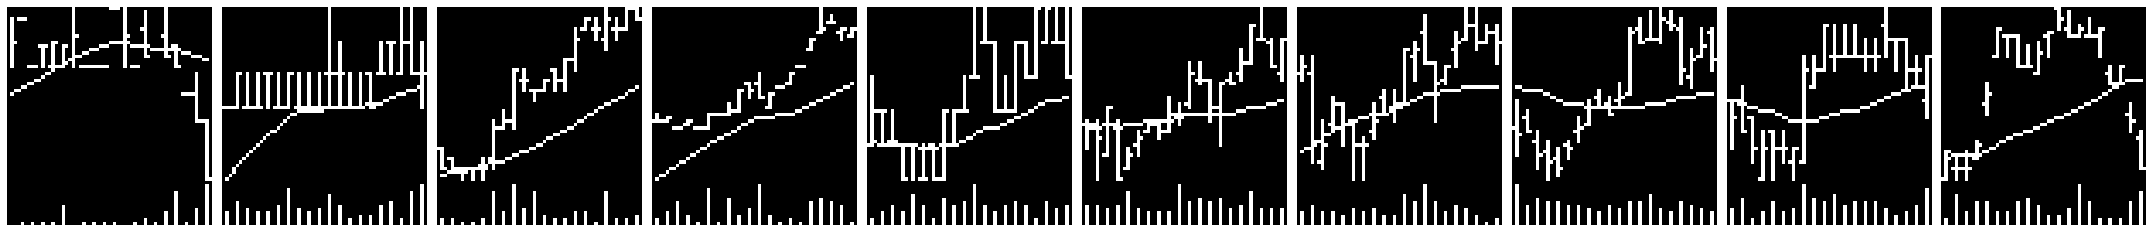

In [65]:
plt.figure(figsize=(30,40))
up_img_lst = []
up_img_lst_content = []
for e,i in enumerate(rand_choices):
    up_img_test = os.path.join(img_path,'up_%s.png'%i) 
    up_img_lst.append(up_img_test)
    img = mpimg.imread(up_img_test) 
    up_img_lst_content.append(img)
    plt.subplot(1,10,e+1)  
    plt.imshow(img, cmap=plt.cm.gray); plt.axis('off'); plt.tight_layout()
plt.show()

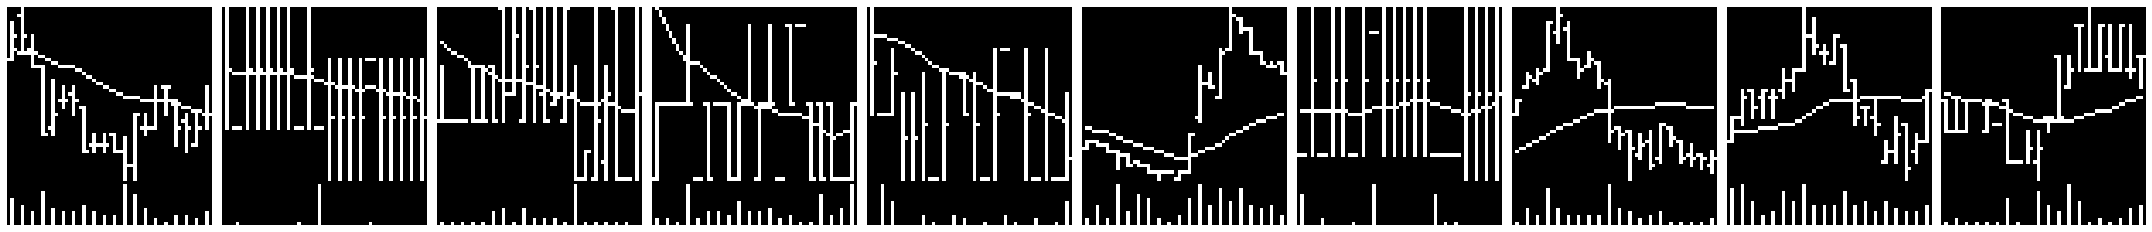

In [66]:
plt.figure(figsize=(30,40))
down_img_lst = []
down_img_lst_content = []
for e,i in enumerate(rand_choices):
    down_img_test = os.path.join(img_path,'down_%s.png'%i)
    down_img_lst.append(down_img_test)
    img = mpimg.imread(down_img_test) 
    down_img_lst_content.append(img)
    plt.subplot(1,10,e+1)  
    plt.imshow(img, cmap=plt.cm.gray); plt.axis('off'); plt.tight_layout()
plt.show()

In [67]:
# Get your input
up_results, down_results = [], []
for up_img_test, down_img_test in zip(up_img_lst, down_img_lst):
    up_img2 = read_image(up_img_test)

    # Preprocess it for your chosen model
    up_img_tensor = up_img2.type(torch.FloatTensor).cuda()
    up_img_tensor /= 255

    # Preprocess your data and feed it to the model
    up_out = model(up_img_tensor.unsqueeze(0))
    print('up_out',up_out)
    print('up_out.squeeze(0).argmax().item()',up_out.squeeze(0).argmax().item())
    # print('out',out.size())
    # Retrieve the CAM by passing the class index and the model output
    up_act_map = cam_extractor(up_out.squeeze(0).argmax().item(), up_out)
    # Resize the CAM and overlay it
    up_img_3 = up_img2.repeat_interleave(3, dim=0)

    up_result = overlay_mask(to_pil_image(up_img_3), to_pil_image(up_act_map[0].squeeze(0), mode="F"), alpha=0.1)
    up_results.append(up_result)

up_out tensor([[-0.5501,  0.1699]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.9125,  0.1411]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.9051,  0.0015]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.6107,  0.1263]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.8429,  0.1588]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.9701,  0.4701]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.8955,  0.2587]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-1.0595,  0.1112]], device='cuda:0', grad_fn=<AddmmBackward0>)
up_out.squeeze(0).argmax().item() 1
up_out tensor([[-0.7538,  0.1975]], device='cuda:0', grad_fn=<AddmmBackward0>)
u

### up trend grad-cam graph 

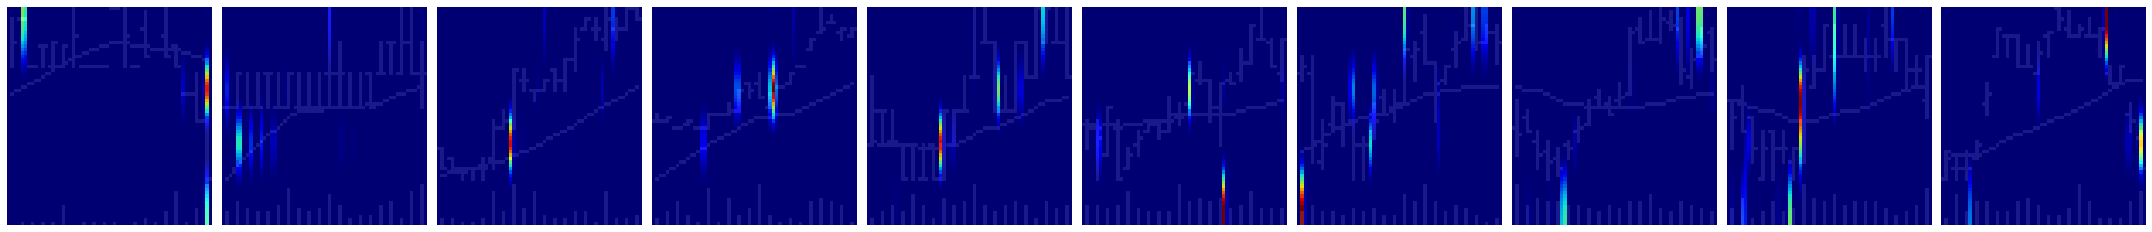

In [68]:
plt.figure(figsize=(30,40))
for i, result in enumerate(up_results):
    # Display it
    plt.subplot(1,10,i+1)
    # print(100+len(up_results)*10+i+1)
    plt.imshow(result); plt.axis('off'); plt.tight_layout()
plt.show()

In [69]:
# Get your input
down_results = []
for up_img_test, down_img_test in zip(up_img_lst, down_img_lst):
    down_img2 = read_image(down_img_test)
    # print(up_img)
    # break

    # Preprocess it for your chosen model
    down_img_tensor = down_img2.type(torch.FloatTensor).cuda()
    down_img_tensor /= 255

    # Preprocess your data and feed it to the model
    down_out = model(down_img_tensor.unsqueeze(0))
    print('down_out',down_out)
    print('down_out.squeeze(0).argmax().item()',down_out.squeeze(0).argmax().item())
    # print('out',out.size())
    # Retrieve the CAM by passing the class index and the model output
    down_act_map = cam_extractor(down_out.squeeze(0).argmax().item(), down_out)
    # Resize the CAM and overlay it
    down_img_3 = down_img2.repeat_interleave(3, dim=0)

    down_result = overlay_mask(to_pil_image(down_img_3), to_pil_image(down_act_map[0].squeeze(0), mode="F"), alpha=0.1)
    down_results.append(down_result)

down_out tensor([[ 0.4655, -0.6952]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.3395, -0.8662]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.5860, -0.4910]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.1512, -0.7898]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.0098, -0.9069]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.3494, -0.5744]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[ 0.1138, -0.8385]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[-0.0236, -0.8906]], device='cuda:0', grad_fn=<AddmmBackward0>)
down_out.squeeze(0).argmax().item() 0
down_out tensor([[-0.1701, -1.1093]], device='cu

### down trend grad-cam graph 

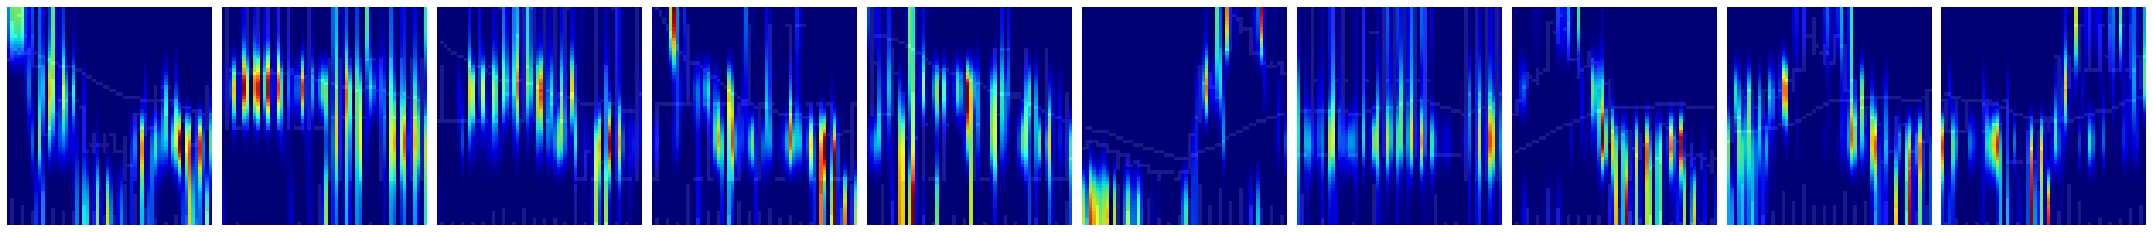

In [70]:
plt.figure(figsize=(30,40))
for i, result in enumerate(down_results):
    # Display it
    plt.subplot(1,10,i+1)
    plt.imshow(result); plt.axis('off'); plt.tight_layout()
plt.show()